In [2]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Configure logging to show debug messages only from our project code
# Set root logger to WARNING to suppress debug from other libraries
logging.getLogger().setLevel(logging.WARNING)

# ignore debug messages from other libraries
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# deterministic random seed for reproducibility
import random
random.seed(42)
np.random.seed(42) 

# import the project root
sys.path.insert(0, '../..')
from load_mnist import load_dataset

# ============================================================================
# FUNCTION DEFINITIONS
# ============================================================================

def load_and_visualize_data(num_points=1000, num_samples=10):
    """Load MNIST data and visualize sample images"""
    print("Loading MNIST dataset...")
    X_data, original_shape = load_dataset(flatten=True, num_points=num_points)
    
    print(f"Data shape: {X_data.shape}")
    print(f"Original image shape: {original_shape}")
    print(f"Data range: [{X_data.min():.3f}, {X_data.max():.3f}]")
    
    # Display some sample images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(min(num_samples, len(X_data))):
        row = i // 5
        col = i % 5
        axes[row, col].imshow(X_data[i].reshape(28, 28), cmap='gray')
        axes[row, col].set_title(f"Sample {i+1}")
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()
    
    return X_data, original_shape

def analyze_pca_components(X_data, n_components_list):
    """Analyze PCA components and explained variance"""
    print("Performing PCA analysis...")
    
    # Fit PCA with full components to analyze explained variance
    pca_full = PCA(n_components=min(X_data.shape[0], X_data.shape[1]))
    pca_full.fit(X_data)
    
    # Plot explained variance ratio
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Cumulative explained variance
    cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
    axes[0, 0].plot(range(1, len(cumulative_var) + 1), cumulative_var, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Number of Components')
    axes[0, 0].set_ylabel('Cumulative Explained Variance Ratio')
    axes[0, 0].set_title('Cumulative Explained Variance')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Mark our chosen components
    for n_comp in n_components_list:
        if n_comp <= len(cumulative_var):
            axes[0, 0].axvline(x=n_comp, color='red', linestyle='--', alpha=0.7)
            axes[0, 0].text(n_comp, cumulative_var[n_comp-1], f'{n_comp}\n({cumulative_var[n_comp-1]:.2f})', 
                    ha='center', va='bottom', fontsize=8)
    
    axes[0, 0].set_xlim(0, 500)
    axes[0, 0].set_ylim(0, 1)
    
    # Individual explained variance (first 100 components)
    axes[0, 1].plot(range(1, 101), pca_full.explained_variance_ratio_[:100], 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Component Number')
    axes[0, 1].set_ylabel('Explained Variance Ratio')
    axes[0, 1].set_title('Individual Component Explained Variance (First 100)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Eigenvalues (first 100 components)
    axes[1, 0].plot(range(1, 101), pca_full.explained_variance_[:100], 'r-', linewidth=2)
    axes[1, 0].set_xlabel('Component Number')
    axes[1, 0].set_ylabel('Eigenvalue')
    axes[1, 0].set_title('Eigenvalues (First 100 Components)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Log scale eigenvalues
    axes[1, 1].semilogy(range(1, 101), pca_full.explained_variance_[:100], 'r-', linewidth=2)
    axes[1, 1].set_xlabel('Component Number')
    axes[1, 1].set_ylabel('Eigenvalue (log scale)')
    axes[1, 1].set_title('Eigenvalues - Log Scale (First 100 Components)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance for our chosen components
    print("\nExplained variance for different number of components:")
    for n_comp in n_components_list:
        if n_comp <= len(cumulative_var):
            print(f"{n_comp:3d} components: {cumulative_var[n_comp-1]:.4f} ({cumulative_var[n_comp-1]*100:.2f}%)")
        else:
            print(f"{n_comp:3d} components: > 1.0000 (> 100%)")
    
    return pca_full

def perform_pca_reconstruction(X_data, n_components_list, n_test_images=20):
    """Perform PCA reconstruction with different numbers of components"""
    print("Performing PCA reconstruction with different numbers of components...")
    
    # Store reconstructions and errors
    reconstructions = {}
    reconstruction_errors = {}
    
    # Select a subset of images for detailed analysis
    test_indices = np.random.choice(len(X_data), n_test_images, replace=False)
    X_test = X_data[test_indices]
    
    for n_comp in tqdm(n_components_list, desc="PCA Reconstruction"):
        # Fit PCA with n_comp components
        pca = PCA(n_components=n_comp)
        pca.fit(X_data)
        
        # Transform and reconstruct
        X_transformed = pca.transform(X_test)
        X_reconstructed = pca.inverse_transform(X_transformed)
        
        # Store results
        reconstructions[n_comp] = X_reconstructed
        
        # Calculate reconstruction error
        mse = mean_squared_error(X_test, X_reconstructed)
        reconstruction_errors[n_comp] = mse
        
        print(f"{n_comp:3d} components: MSE = {mse:.6f}, "
              f"Explained variance = {np.sum(pca.explained_variance_ratio_):.4f}")
    
    return reconstructions, reconstruction_errors, X_test

def plot_reconstruction_errors(reconstruction_errors):
    """Plot reconstruction error analysis"""
    components = list(reconstruction_errors.keys())
    errors = list(reconstruction_errors.values())
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    
    axes[0].plot(components, errors, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Components')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].set_title('Reconstruction Error vs Number of Components')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].semilogy(components, errors, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Mean Squared Error (log scale)')
    axes[1].set_title('Reconstruction Error vs Number of Components (Log Scale)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nReconstruction errors summary:")
    for n_comp, error in reconstruction_errors.items():
        print(f"{n_comp:3d} components: MSE = {error:.6f}")
    
    n_components_list = list(reconstruction_errors.keys())
    print(f"\nError reduction from {n_components_list[0]} to {n_components_list[-1]} components: "
          f"{(reconstruction_errors[n_components_list[0]] / reconstruction_errors[n_components_list[-1]]):,.1f}x")

def visualize_reconstructions(X_test, reconstructions, reconstruction_errors, n_components_list, n_vis_images=5):
    """Visualize original and reconstructed images"""
    print("Visualizing original and reconstructed images...")
    
    # Select a few representative images for visualization
    vis_indices = list(range(min(n_vis_images, len(X_test))))
    
    # Create a comprehensive visualization
    fig, axes = plt.subplots(n_vis_images, len(n_components_list) + 1, 
                            figsize=(2 * (len(n_components_list) + 1), 2 * n_vis_images))
    
    for i, img_idx in enumerate(vis_indices):
        # Original image
        axes[i, 0].imshow(X_test[img_idx].reshape(28, 28), cmap='gray')
        axes[i, 0].set_title(f'Original\nImage {img_idx+1}')
        axes[i, 0].axis('off')
        
        # Reconstructed images with different components
        for j, n_comp in enumerate(n_components_list):
            reconstructed = reconstructions[n_comp][img_idx]
            axes[i, j+1].imshow(reconstructed.reshape(28, 28), cmap='gray')
            
            # Calculate individual image error
            img_error = mean_squared_error(X_test[img_idx:img_idx+1], 
                                         reconstructed.reshape(1, -1))
            axes[i, j+1].set_title(f'{n_comp} comp.\nMSE={img_error:.4f}')
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

def create_error_maps(X_test, reconstructions, reconstruction_errors, n_components_list, sample_idx=0):
    """Create detailed error maps for reconstruction analysis"""
    fig, axes = plt.subplots(2, len(n_components_list), figsize=(3 * len(n_components_list), 6))
    
    for j, n_comp in enumerate(n_components_list):
        # Reconstructed image
        reconstructed = reconstructions[n_comp][sample_idx]
        axes[0, j].imshow(reconstructed.reshape(28, 28), cmap='gray')
        axes[0, j].set_title(f'{n_comp} Components\nMSE={reconstruction_errors[n_comp]:.4f}')
        axes[0, j].axis('off')
        
        # Difference (error) image
        difference = np.abs(X_test[sample_idx] - reconstructed)
        im = axes[1, j].imshow(difference.reshape(28, 28), cmap='hot')
        axes[1, j].set_title(f'Error Map\nMax={difference.max():.4f}')
        axes[1, j].axis('off')
        
        # Add colorbar for error map
        plt.colorbar(im, ax=axes[1, j], shrink=0.8)
    
    plt.suptitle(f'PCA Reconstruction Analysis - Sample Image {sample_idx+1}', fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_principal_components(pca_full, n_components_to_show=16):
    """Visualize principal components as images"""
    print("Visualizing principal components...")
    
    # Show the first few principal components as images
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    
    for i in range(n_components_to_show):
        row = i // 4
        col = i % 4
        
        # Get the i-th principal component
        component = pca_full.components_[i]
        
        # Normalize for visualization
        component_norm = (component - component.min()) / (component.max() - component.min())
        
        axes[row, col].imshow(component_norm.reshape(28, 28), cmap='gray')
        axes[row, col].set_title(f'PC {i+1}\nVar: {pca_full.explained_variance_ratio_[i]:.4f}')
        axes[row, col].axis('off')
    
    plt.suptitle('First 16 Principal Components', fontsize=16)
    plt.tight_layout()
    plt.show()

def show_progressive_reconstruction(X_data, X_test, n_components_list, test_img_idx=0):
    """Show progressive reconstruction with increasing components"""
    print("\nAnalyzing component contributions...")
    
    # Choose one test image for detailed analysis
    test_img = X_test[test_img_idx]
    
    # Get PCA with maximum components we're interested in
    pca_max = PCA(n_components=n_components_list[-1])
    pca_max.fit(X_data)
    
    # Transform the test image
    coefficients = pca_max.transform(test_img.reshape(1, -1)).flatten()
    
    # Show progressive reconstruction
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    reconstruction_steps = [5, 10, 25, 50, 100, 200, 300, 400]
    for i, n_comp in enumerate(reconstruction_steps):
        if i >= 8:  # Only show first 8 steps
            break
        
        # Partial reconstruction using first n_comp components
        partial_coeffs = coefficients[:n_comp]
        partial_components = pca_max.components_[:n_comp]
        
        reconstruction = pca_max.mean_ + np.dot(partial_coeffs, partial_components)
        
        row = i // 4
        col = i % 4
        
        axes[row, col].imshow(reconstruction.reshape(28, 28), cmap='gray')
        error = mean_squared_error(test_img.reshape(1, -1), reconstruction.reshape(1, -1))
        axes[row, col].set_title(f'{n_comp} components\nMSE: {error:.4f}')
        axes[row, col].axis('off')
    
    plt.suptitle(f'Progressive PCA Reconstruction - Test Image {test_img_idx+1}', fontsize=16)
    plt.tight_layout()
    plt.show()

def quantitative_analysis(X_data, X_test, pca_full, reconstruction_errors, n_components_list):
    """Perform quantitative analysis and create summary"""
    print("Performing quantitative analysis...")
    
    # Calculate compression ratios
    original_size = X_data.shape[1]  # 784 pixels
    print(f"Original image size: {original_size} pixels")
    print(f"Dataset size: {len(X_data)} images")
    print(f"\nCompression analysis:")
    
    compression_ratios = {}
    for n_comp in n_components_list:
        ratio = original_size / n_comp  # Simplified ratio based on coefficients only
        compression_ratios[n_comp] = ratio
        
        print(f"{n_comp:3d} components: {ratio:.1f}x compression, "
              f"MSE: {reconstruction_errors[n_comp]:.6f}, "
              f"Explained var: {np.sum(pca_full.explained_variance_ratio_[:n_comp]):.4f}")
    
    # Plot compression ratio vs reconstruction error
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    components = list(compression_ratios.keys())
    ratios = list(compression_ratios.values())
    errors = [reconstruction_errors[comp] for comp in components]
    
    axes[0].plot(ratios, errors, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Compression Ratio')
    axes[0].set_ylabel('Reconstruction Error (MSE)')
    axes[0].set_title('Compression Ratio vs Reconstruction Error')
    axes[0].grid(True, alpha=0.3)
    
    # Add labels for each point
    for i, (ratio, error, comp) in enumerate(zip(ratios, errors, components)):
        axes[0].annotate(f'{comp}', (ratio, error), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8)
    
    explained_vars = [np.sum(pca_full.explained_variance_ratio_[:comp]) for comp in components]
    axes[1].plot(explained_vars, errors, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Explained Variance Ratio')
    axes[1].set_ylabel('Reconstruction Error (MSE)')
    axes[1].set_title('Explained Variance vs Reconstruction Error')
    axes[1].grid(True, alpha=0.3)
    
    # Add labels for each point
    for i, (var, error, comp) in enumerate(zip(explained_vars, errors, components)):
        axes[1].annotate(f'{comp}', (var, error), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return print_summary(X_data, X_test, reconstruction_errors, pca_full, n_components_list, original_size)

def print_summary(X_data, X_test, reconstruction_errors, pca_full, n_components_list, original_size):
    """Print comprehensive summary statistics"""
    print(f"\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    print(f"Dataset: {len(X_data)} MNIST images ({original_size} pixels each)")
    print(f"Test set: {len(X_test)} images")
    print(f"\nPCA Analysis Results:")
    
    best_comp = min(reconstruction_errors.keys(), key=lambda k: reconstruction_errors[k])
    worst_comp = max(reconstruction_errors.keys(), key=lambda k: reconstruction_errors[k])
    
    print(f"• Best reconstruction: {best_comp} components (MSE: {reconstruction_errors[best_comp]:.6f})")
    print(f"• Worst reconstruction: {worst_comp} components (MSE: {reconstruction_errors[worst_comp]:.6f})")
    print(f"• Error reduction: {reconstruction_errors[worst_comp]/reconstruction_errors[best_comp]:.1f}x")
    
    print(f"\nExplained Variance:")
    for comp in [50, 100, 200, 400]:
        if comp in n_components_list:
            var_explained = np.sum(pca_full.explained_variance_ratio_[:comp])
            print(f"• {comp:3d} components: {var_explained:.4f} ({var_explained*100:.2f}%)")
    
    print(f"\nCompression Ratios (coefficients only):")
    for comp in [50, 100, 200, 400]:
        if comp in n_components_list:
            ratio = original_size / comp
            print(f"• {comp:3d} components: {ratio:.1f}x compression")
    
    print(f"\n" + "="*60)

print("All functions loaded successfully!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All functions loaded successfully!


Loading MNIST dataset...
Data shape: (1000, 784)
Original image shape: (1000, 1, 28, 28)
Data range: [0.000, 1.000]
Data shape: (1000, 784)
Original image shape: (1000, 1, 28, 28)
Data range: [0.000, 1.000]


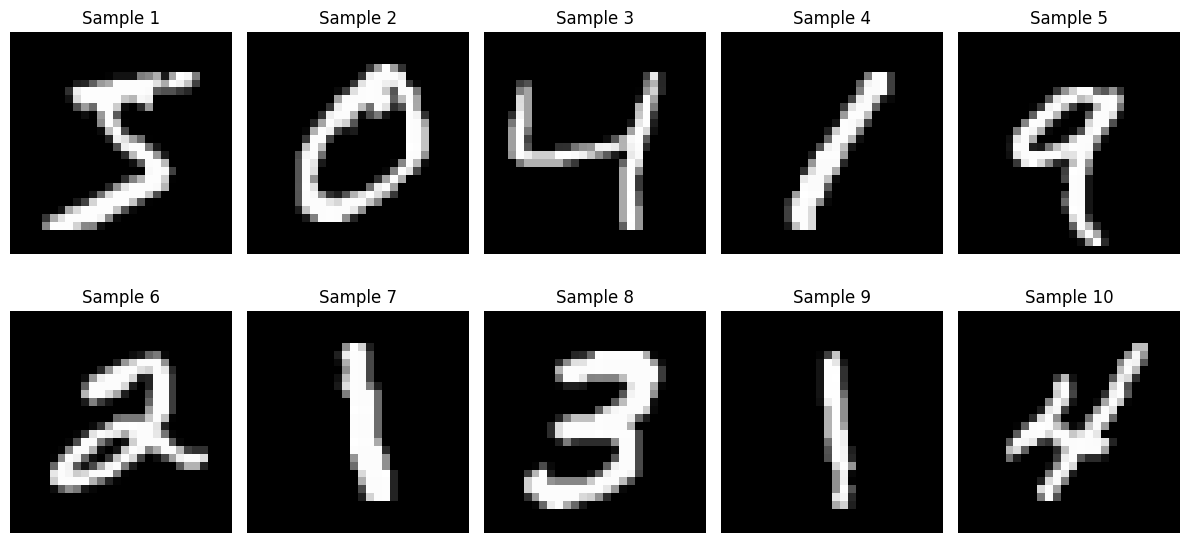

In [3]:
# Load and visualize MNIST data
X_data, original_shape = load_and_visualize_data(num_points=1000, num_samples=10)

Performing PCA analysis...


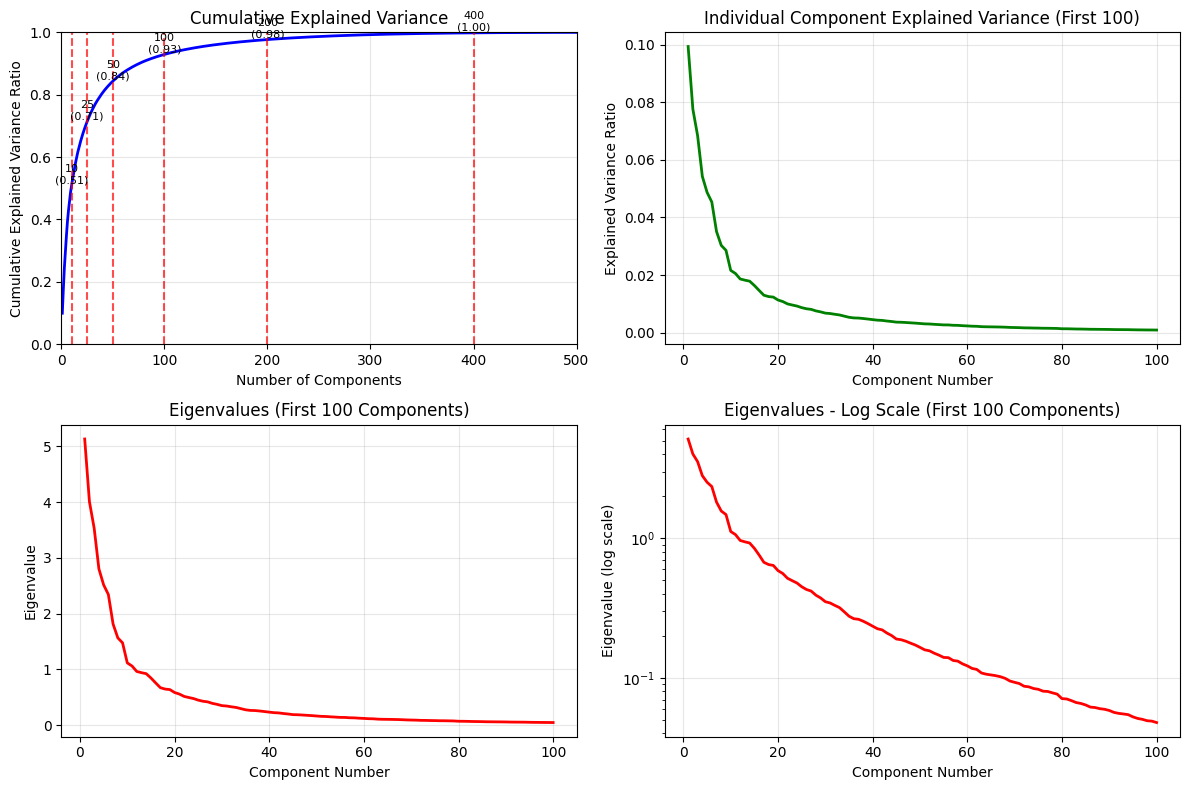


Explained variance for different number of components:
 10 components: 0.5092 (50.92%)
 25 components: 0.7132 (71.32%)
 50 components: 0.8434 (84.34%)
100 components: 0.9291 (92.91%)
200 components: 0.9769 (97.69%)
400 components: 0.9984 (99.84%)


In [4]:
# Define different levels of basis keeping
n_components_list = [10, 25, 50, 100, 200, 400]

# Analyze PCA components and explained variance
pca_full = analyze_pca_components(X_data, n_components_list)

Performing PCA reconstruction with different numbers of components...


PCA Reconstruction:   0%|          | 0/6 [00:00<?, ?it/s]

 10 components: MSE = 0.030312, Explained variance = 0.5092
 25 components: MSE = 0.016431, Explained variance = 0.7132


PCA Reconstruction:  50%|█████     | 3/6 [00:00<00:00,  9.22it/s]

 50 components: MSE = 0.009527, Explained variance = 0.8434


PCA Reconstruction:  67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

100 components: MSE = 0.004328, Explained variance = 0.9288


PCA Reconstruction:  83%|████████▎ | 5/6 [00:02<00:00,  1.36it/s]

200 components: MSE = 0.001453, Explained variance = 0.9766


PCA Reconstruction: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]

400 components: MSE = 0.000105, Explained variance = 0.9984


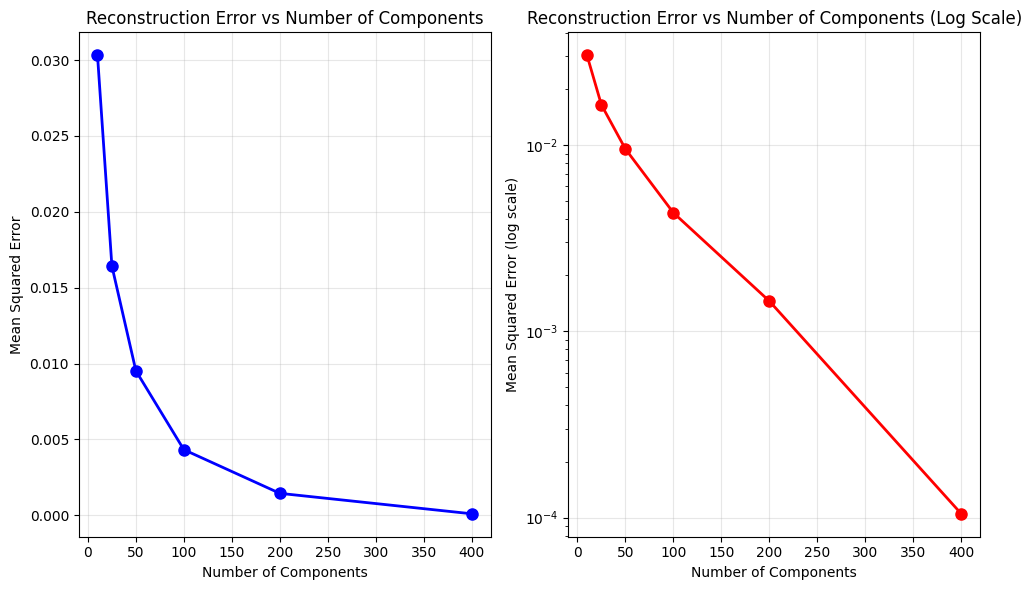


Reconstruction errors summary:
 10 components: MSE = 0.030312
 25 components: MSE = 0.016431
 50 components: MSE = 0.009527
100 components: MSE = 0.004328
200 components: MSE = 0.001453
400 components: MSE = 0.000105

Error reduction from 10 to 400 components: 289.1x


In [5]:
# Perform PCA reconstruction with different numbers of components
reconstructions, reconstruction_errors, X_test = perform_pca_reconstruction(X_data, n_components_list, n_test_images=20)

# Plot reconstruction error analysis
plot_reconstruction_errors(reconstruction_errors)

Visualizing original and reconstructed images...


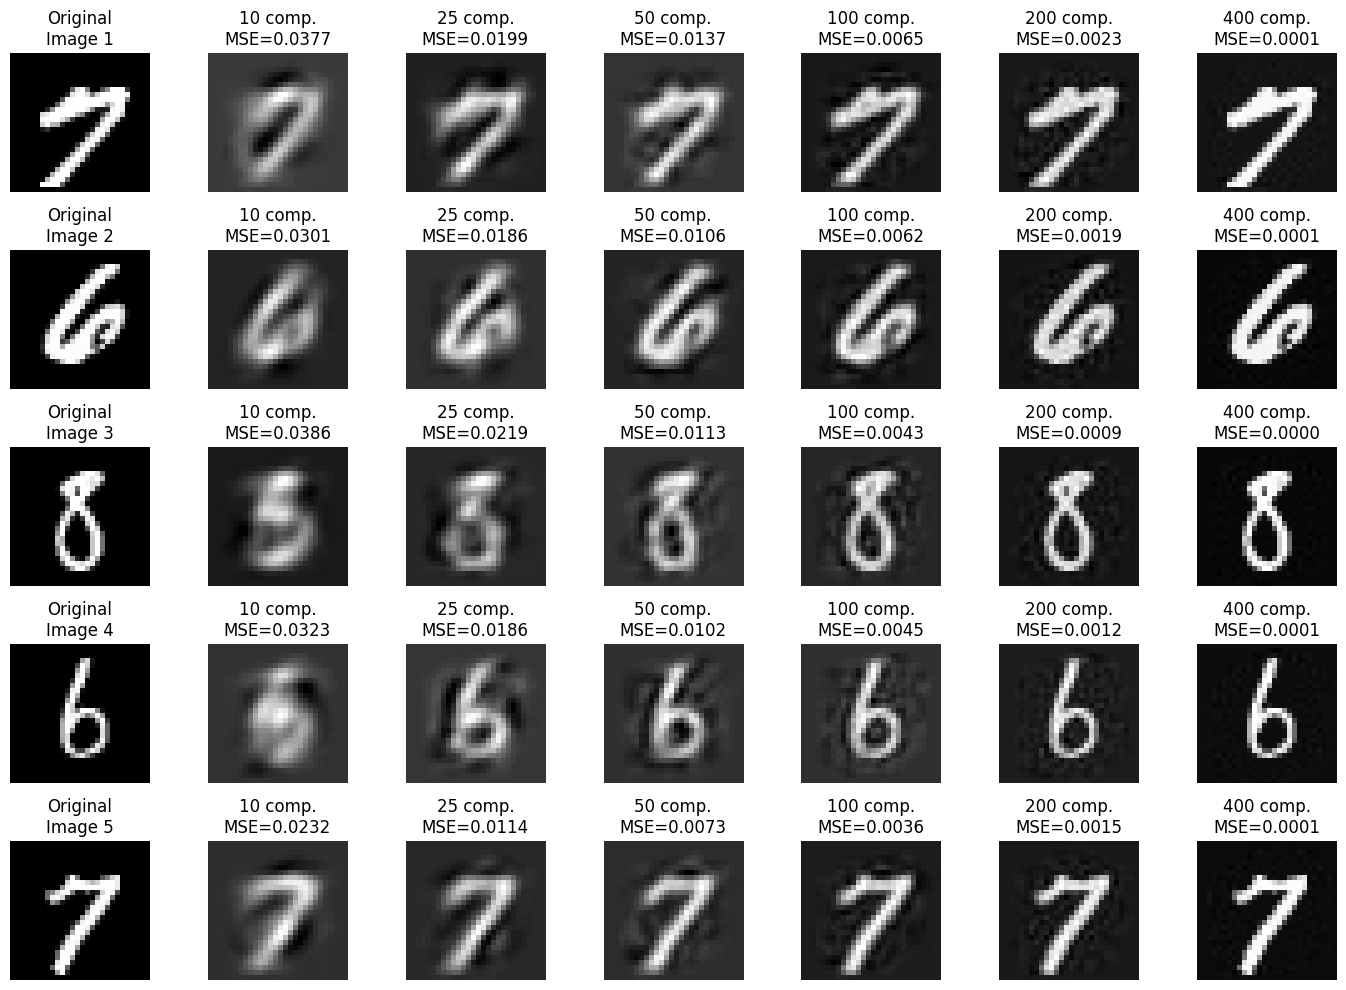

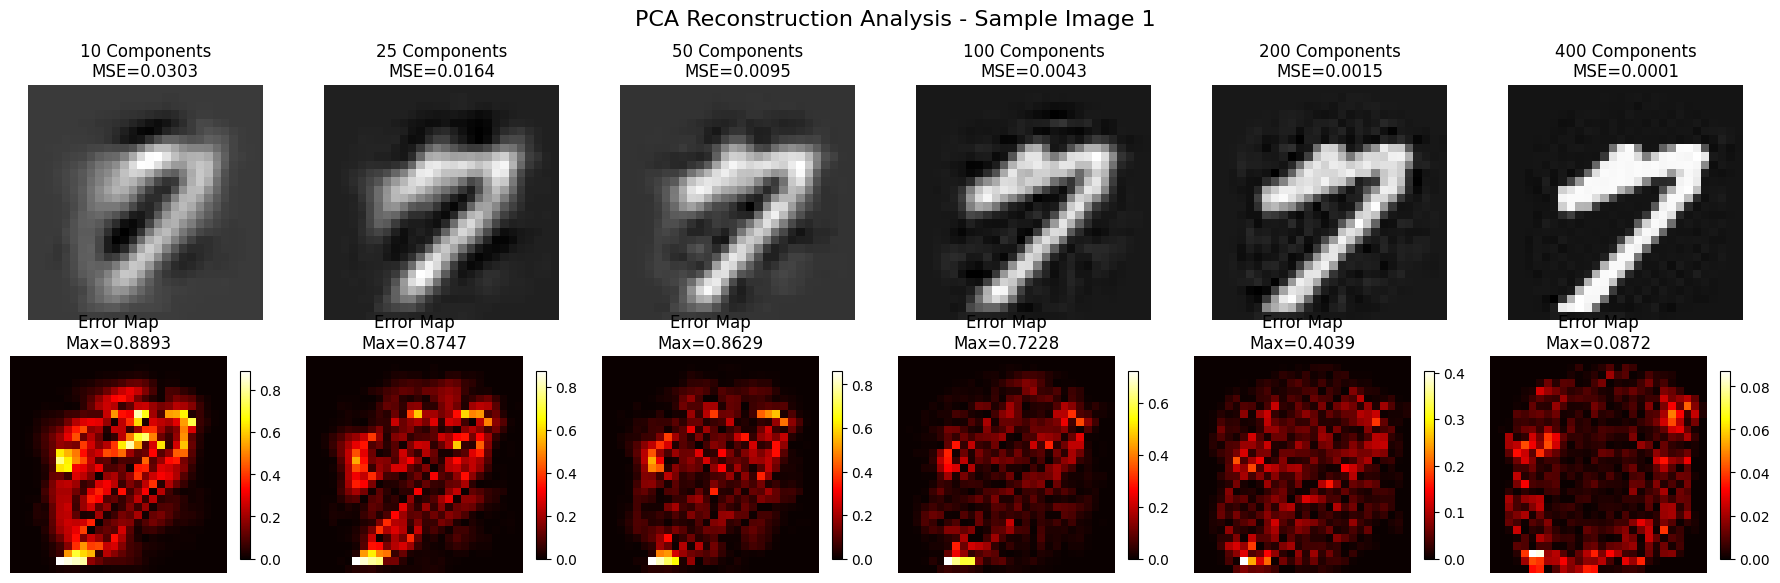

In [6]:
# Visualize original and reconstructed images
visualize_reconstructions(X_test, reconstructions, reconstruction_errors, n_components_list, n_vis_images=5)

# Create detailed error maps for reconstruction analysis
create_error_maps(X_test, reconstructions, reconstruction_errors, n_components_list, sample_idx=0)

Visualizing principal components...


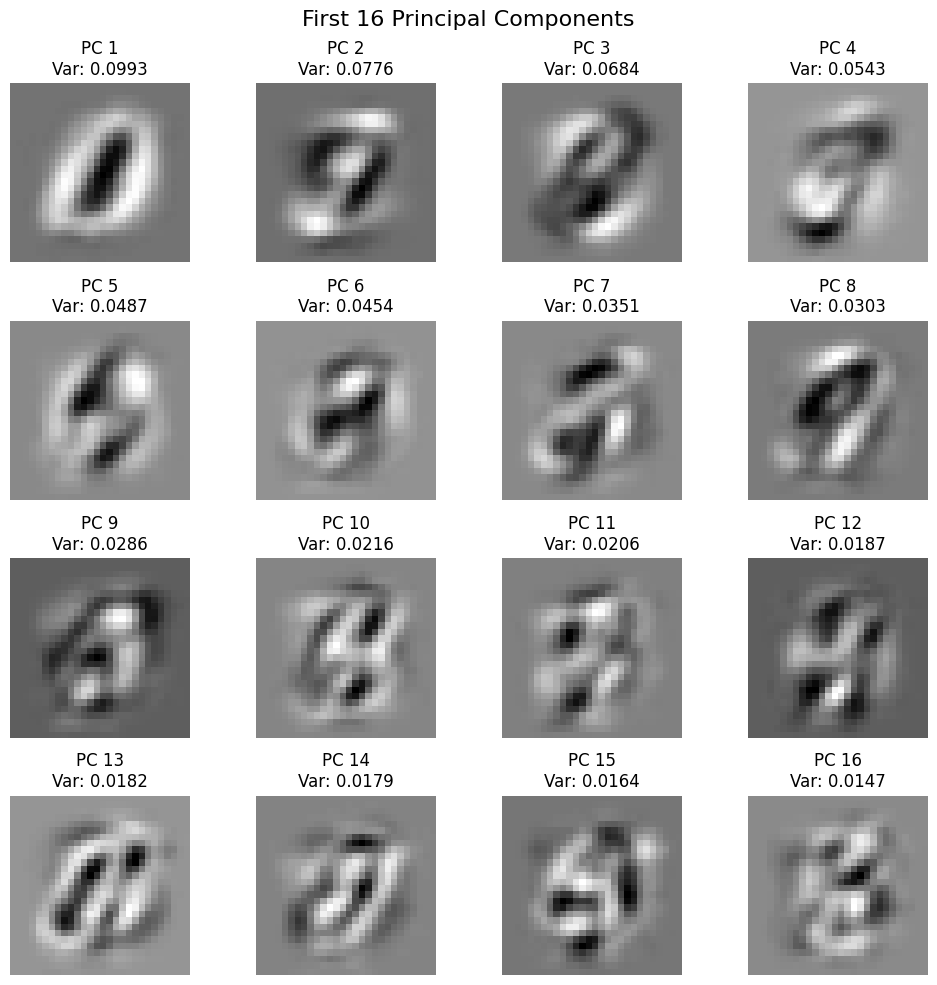


Analyzing component contributions...


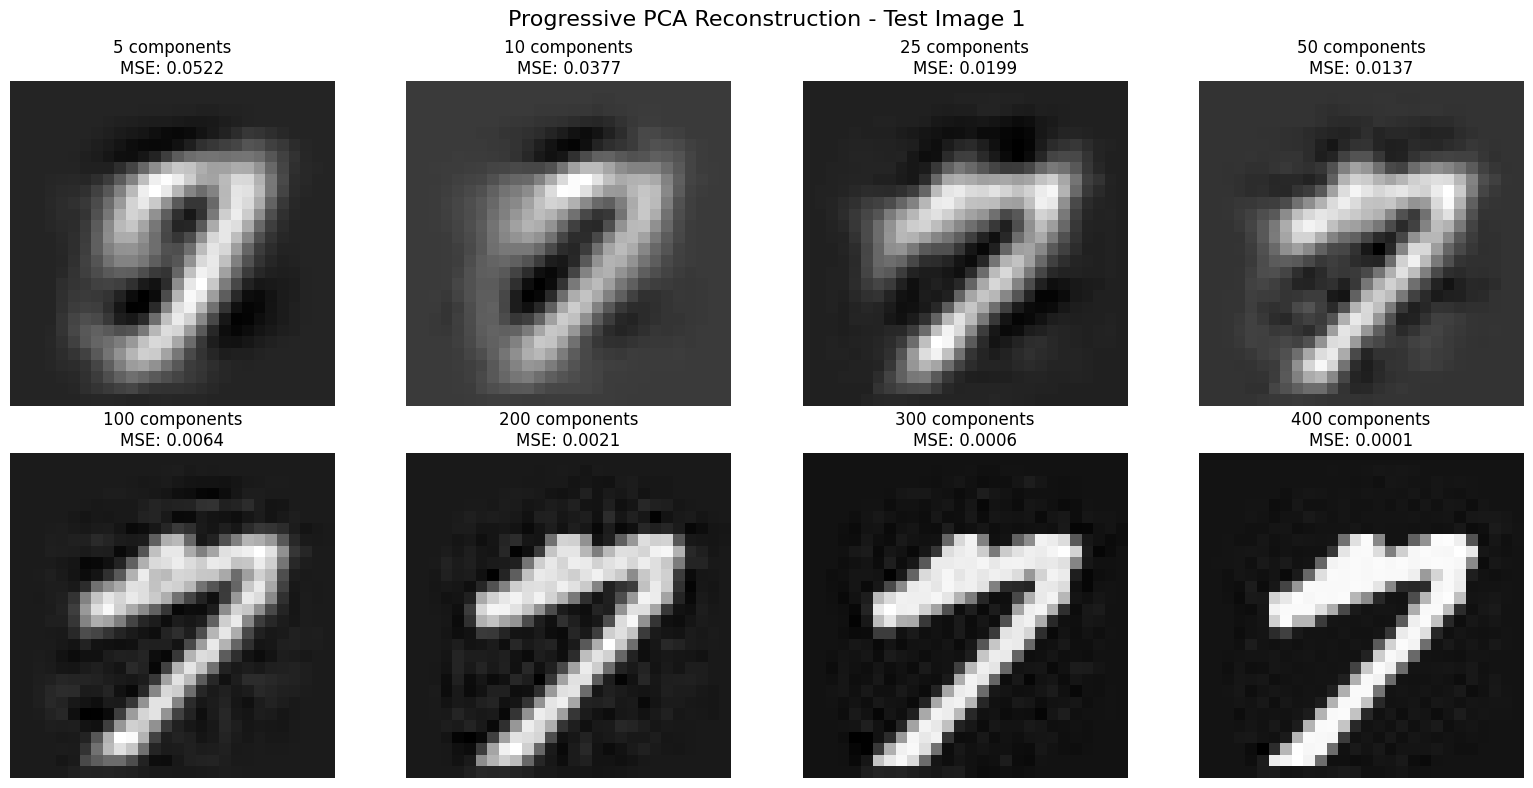

In [7]:
# Visualize principal components as images
visualize_principal_components(pca_full, n_components_to_show=16)

# Show progressive reconstruction with increasing components
show_progressive_reconstruction(X_data, X_test, n_components_list, test_img_idx=0)

Performing quantitative analysis...
Original image size: 784 pixels
Dataset size: 1000 images

Compression analysis:
 10 components: 78.4x compression, MSE: 0.030312, Explained var: 0.5092
 25 components: 31.4x compression, MSE: 0.016431, Explained var: 0.7132
 50 components: 15.7x compression, MSE: 0.009527, Explained var: 0.8434
100 components: 7.8x compression, MSE: 0.004328, Explained var: 0.9291
200 components: 3.9x compression, MSE: 0.001453, Explained var: 0.9769
400 components: 2.0x compression, MSE: 0.000105, Explained var: 0.9984


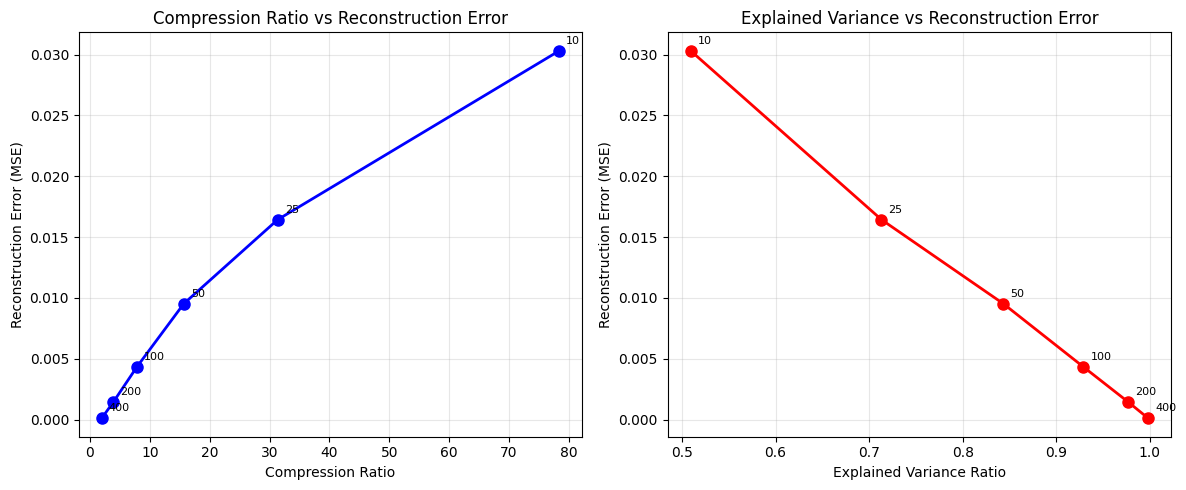


SUMMARY STATISTICS
Dataset: 1000 MNIST images (784 pixels each)
Test set: 20 images

PCA Analysis Results:
• Best reconstruction: 400 components (MSE: 0.000105)
• Worst reconstruction: 10 components (MSE: 0.030312)
• Error reduction: 289.1x

Explained Variance:
•  50 components: 0.8434 (84.34%)
• 100 components: 0.9291 (92.91%)
• 200 components: 0.9769 (97.69%)
• 400 components: 0.9984 (99.84%)

Compression Ratios (coefficients only):
•  50 components: 15.7x compression
• 100 components: 7.8x compression
• 200 components: 3.9x compression
• 400 components: 2.0x compression



In [8]:
# Perform quantitative analysis and print summary
quantitative_analysis(X_data, X_test, pca_full, reconstruction_errors, n_components_list)